In [1]:
__author__ = 'ORI'

from matplotlib.collections import LineCollection

import numpy as np
import scipy.io
import sys, os
import matplotlib.pyplot as plt
# I should learn how to load libraries in a more elegant way



sys.path.append(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\OriKerasExtension')
#import OriKerasExtension
import ThesisHelper
#reload(OriKerasExtension)
reload(ThesisHelper)
from   ThesisHelper import LoadSingleSubjectPython, readCompleteMatFile, ExtractDataVer4
import P300Prediction
reload(P300Prediction)
from P300Prediction import accuracy_by_repetition, create_target_table


sys.path.append(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\OriKerasExtension')
#import OriKerasExtension
import ThesisHelper
from sklearn.metrics import roc_curve, auc, roc_auc_score
import P300Prediction
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from scipy import stats
from sklearn.cross_validation import StratifiedShuffleSplit

#reload(OriKerasExtension)
reload(ThesisHelper)
from ThesisHelper import LoadSingleSubjectPython, readCompleteMatFile, ExtractDataVer4
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

reload(P300Prediction)
from P300Prediction import accuracy_by_repetition, create_target_table


# [all_target, all_non_target] = LoadSingleSubjectPython(r'C:\Users\ORI\Documents\Thesis\dataset_all\RSVP_Color116msVPfat.mat')



# all_samples = np.vstack((all_target,all_non_target))


# '''
# Create the tagging column
# '''
# all_tags = np.vstack((np.ones((all_target.shape[0],1)), np.zeros((all_non_target.shape[0],1))))






Using Theano backend.


Using gpu device 0: GeForce GT 740M (CNMeM is disabled)


In [3]:
# mne part
from __future__ import print_function

import mne
import numpy as np

# Generate some random data
data = np.random.randn(5, 1000)

# Initialize an info structure
info = mne.create_info(
    ch_names=['MEG1', 'MEG2', 'EEG1', 'EEG2', 'EOG'],
    ch_types=['grad', 'grad', 'eeg', 'eeg', 'eog'],
    sfreq=100
)

custom_raw = mne.io.RawArray(data, info)
print(custom_raw)

Creating RawArray with float64 data, n_channels=5, n_times=1000
    Range : 0 ... 999 =      0.000 ...     9.990 secs
Ready.
<RawArray  |  n_channels x n_times : 5 x 1000>


In [2]:
def create_evaluation_data(gcd_res, down_samples_param):
#     gcd_res = readCompleteMatFile(file_name)
    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'], gcd_res['target'],
                                    -200, 800)
    # print  data_for_eval

    temp_data_for_eval = downsample_data(data_for_eval[0], data_for_eval[0].shape[1], down_samples_param)

    test_data_gcd, test_target_gcd = temp_data_for_eval[gcd_res['train_mode'] != 1], data_for_eval[1][
        gcd_res['train_mode'] != 1]
    return test_data_gcd, test_target_gcd


def downsample_data(data, number_of_original_samples, down_samples_param):


    new_number_of_time_stamps = number_of_original_samples / down_samples_param


    # print  data_for_eval
    temp_data_for_eval = np.zeros((data.shape[0], new_number_of_time_stamps, data.shape[2]))

    for new_i, i in enumerate(range(0, number_of_original_samples, down_samples_param)):
        temp_data_for_eval[:, new_i, :] = np.mean(data[:, range(i, (i + down_samples_param)), :], axis=1)
    return temp_data_for_eval


def create_train_data(gcd_res, down_samples_param):
    all_positive_train = []
    all_negative_train = []

#     others = ["RSVP_Color116msVPgcd.mat"]


#     for other_file_name in others:
#         file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(other_file_name)
#     gcd_res = readCompleteMatFile(file_name)
    last_time_stamp = 800
    fist_time_stamp = -200


    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'],
                                    gcd_res['target'], fist_time_stamp, last_time_stamp)

    # total_time = last_time_stamp - fist_time_stamp
    # number_of_original_samples = total_time / 5
    # new_number_of_time_stamps = number_of_original_samples / down_samples_param
    #
    #
    # # print  data_for_eval
    # temp_data_for_eval = np.zeros((data_for_eval[0].shape[0], new_number_of_time_stamps, data_for_eval[0].shape[2]))
    #
    # for new_i, i in enumerate(range(0, 200, new_number_of_time_stamps)):
    #     temp_data_for_eval[:, new_i, :] = np.mean(data_for_eval[0][:, range(i, (i + new_number_of_time_stamps)), :], axis=1)
    print data_for_eval[0].shape
    temp_data_for_eval = downsample_data(data_for_eval[0],data_for_eval[0].shape[1], down_samples_param)

    positive_train_data_gcd = temp_data_for_eval[
        np.all([gcd_res['train_mode'] == 1, gcd_res['target'] == 1], axis=0)]
    negative_train_data_gcd = temp_data_for_eval[
        np.all([gcd_res['train_mode'] == 1, gcd_res['target'] == 0], axis=0)]
    all_positive_train.append(positive_train_data_gcd)
    all_negative_train.append(negative_train_data_gcd)

    positive_train_data_gcd = np.vstack(all_positive_train)
    negative_train_data_gcd = np.vstack(all_negative_train)

    all_data = np.vstack([positive_train_data_gcd, negative_train_data_gcd])

    all_tags = np.vstack(
        [np.ones((positive_train_data_gcd.shape[0], 1)), np.zeros((negative_train_data_gcd.shape[0], 1))])
    categorical_tags = to_categorical(all_tags)

    shuffeled_samples, suffule_tags = shuffle(all_data, categorical_tags, random_state=0)
    # shuffeled_samples, suffule_tags = (all_data, categorical_tags)
    return shuffeled_samples, suffule_tags


def create_data_for_compare_by_repetition(file_name):
    gcd_res = readCompleteMatFile(file_name)
    sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
                       train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
                       stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])
    return sub_gcd_res

#shuffeled_samples, suffule_tags = create_train_data(file_name=None, down_samples_param=5)
# shuffeled_samples, suffule_tags = create_train_data(file_name=None, down_samples_param=20)



In [3]:
results = []
for subject_name in data_set_locations:
file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
gcd_res = readCompleteMatFile(file_name)
subject_results = dict()
for i in range(4):
model.set_weights(original_weights)
down_sample_param = 8
shuffeled_samples, suffule_tags = create_train_data(gcd_res, down_samples_param=down_sample_param)
print shuffeled_samples.shape

sss = list(StratifiedShuffleSplit(suffule_tags[:, 0], n_iter=1, test_size=0.1))
checkpointer = ModelCheckpoint(filepath=r"c:\temp\25_dec_lstm_with_ds_2.hdf5", verbose=1, save_best_only=True)
print shuffeled_samples[sss[0][0]].shape
print stats.zscore(shuffeled_samples[sss[0][0]], axis=1).shape
model.fit(stats.zscore(shuffeled_samples[sss[0][0]], axis=1), suffule_tags[sss[0][0]],
          nb_epoch=20, show_accuracy=True, verbose=1, validation_data=(
    stats.zscore(shuffeled_samples[sss[0][1]], axis=1), suffule_tags[sss[0][1]]),
          class_weight={0: 1, 1: 50},
          callbacks=[checkpointer])





test_data_gcd, test_target_gcd = create_evaluation_data(gcd_res, down_samples_param=down_sample_param)

test_prediction = model.predict(stats.zscore(test_data_gcd, axis=1), verbose=1)

x, y, _ = roc_curve(test_target_gcd, test_prediction[:, 1])



# This is the ROC curve
# plt.plot(x, y)
# plt.show()
auc_score = roc_auc_score(test_target_gcd, test_prediction[:, 1])
print "auc_score:{0}".format(auc_score)
sub_gcd_res = create_data_for_compare_by_repetition(file_name)
# sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
# train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
# stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])

_, _, gt_data_for_sum = create_target_table(sub_gcd_res, test_target_gcd)
_, _, actual_data_for_sum = create_target_table(sub_gcd_res, test_prediction[:, 1])
subject_results[i] = dict(test_prediction=test_prediction, 
                          auc_score=auc_score,
                          acc_by_rep=accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))

print "accuracy_by_repetition {0}".format(
    accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))

    results.append(dict(subject_name=subject_name, subject_results=subject_results))


(18600L, 200L, 55L)
(7200L, 25L, 55L)
(6480L, 25L, 55L)
(6480L, 25L, 55L)
Train on 6480 samples, validate on 720 samples
Epoch 1/20
6480/6480 [==============================] - 6s - loss: 0.8877 - acc: 0.9529 - val_loss: 0.1466 - val_acc: 0.9667
Epoch 00000: val_loss improved from inf to 0.14658, saving model to c:\temp\25_dec_lstm_with_ds_2.hdf5
Epoch 2/20
6480/6480 [==============================] - 6s - loss: 0.5520 - acc: 0.9667 - val_loss: 0.1320 - val_acc: 0.9667
Epoch 00001: val_loss improved from 0.14658 to 0.13196, saving model to c:\temp\25_dec_lstm_with_ds_2.hdf5
Epoch 3/20
6480/6480 [==============================] - 6s - loss: 0.4942 - acc: 0.9667 - val_loss: 0.1220 - val_acc: 0.9667
Epoch 00002: val_loss improved from 0.13196 to 0.12199, saving model to c:\temp\25_dec_lstm_with_ds_2.hdf5
Epoch 4/20
6480/6480 [==============================] - 6s - loss: 0.4325 - acc: 0.9667 - val_loss: 0.1188 - val_acc: 0.9667
Epoch 00003: val_loss improved from 0.12199 to 0.11875, saving

In [4]:
# np.save(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\ipytho_notebook\reports\6_feb_2016_explore_LSTM.npy',results)
[(sub['subject_name'], [sub['subject_results'][i]['acc_by_rep'] for i in range(4) ]) for sub in results]


[('RSVP_Color116msVPicr.mat',
  [0.9736842105263158,
   0.9473684210526315,
   0.8947368421052632,
   0.9473684210526315]),
 ('RSVP_Color116msVPpia.mat',
  [0.8444444444444444,
   0.7777777777777778,
   0.8222222222222222,
   0.7777777777777778]),
 ('RSVP_Color116msVPfat.mat',
  [0.9736842105263158, 1.0, 0.9473684210526315, 0.9736842105263158]),
 ('RSVP_Color116msVPgcb.mat',
  [0.8048780487804879,
   0.8048780487804879,
   0.7560975609756098,
   0.7804878048780488]),
 ('RSVP_Color116msVPgcc.mat',
  [0.918918918918919,
   0.8918918918918919,
   0.8918918918918919,
   0.9459459459459459]),
 ('RSVP_Color116msVPgcd.mat',
  [0.8260869565217391,
   0.8260869565217391,
   0.717391304347826,
   0.7391304347826086]),
 ('RSVP_Color116msVPgcf.mat',
  [0.9473684210526315,
   0.9473684210526315,
   0.9736842105263158,
   0.9473684210526315]),
 ('RSVP_Color116msVPgcg.mat',
  [0.7608695652173914,
   0.8043478260869565,
   0.8695652173913043,
   0.8260869565217391]),
 ('RSVP_Color116msVPgch.mat',
  [0

In [32]:
results

[{'subject_name': 'RSVP_Color116msVPicr.mat',
  'subject_results': {0: {'acc_by_rep': 0.8333333333333334,
    'auc_score': 0.86468444018731372,
    'test_prediction': array([[ 0.84226179,  0.15773819],
           [ 0.86728626,  0.13271372],
           [ 0.95803291,  0.04196712],
           ..., 
           [ 0.99279225,  0.00720776],
           [ 0.97658044,  0.02341963],
           [ 0.59612763,  0.40387237]])},
   1: {'acc_by_rep': 0.9444444444444444,
    'auc_score': 0.88640059599829712,
    'test_prediction': array([[ 0.98302346,  0.01697655],
           [ 0.96586055,  0.03413945],
           [ 0.97163624,  0.02836375],
           ..., 
           [ 0.99284935,  0.00715065],
           [ 0.50014472,  0.49985528],
           [ 0.92243224,  0.07756776]])},
   2: {'acc_by_rep': 1.0,
    'auc_score': 0.88121913580246902,
    'test_prediction': array([[ 0.92694533,  0.07305466],
           [ 0.95512652,  0.04487346],
           [ 0.96301597,  0.03698402],
           ..., 
           [ 0

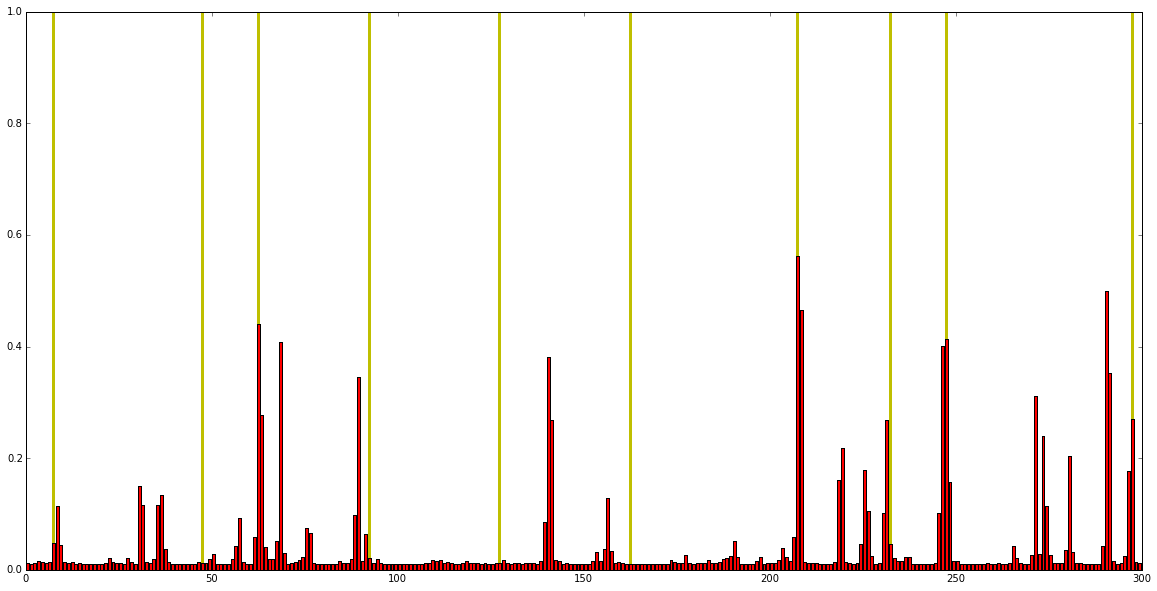

In [14]:
%matplotlib inline 
# %matplotlib qt 
import matplotlib.cm as cm
plt.figure(figsize=(20,10))
plt.bar(range(300), test_target_gcd[0:300], color='y', edgecolor = "none")
plt.bar(range(300), test_prediction[0:300,1], color='r')
plt.show()




In [37]:
%matplotlib qt 
import matplotlib.cm as cm
plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
plt.imshow(test_target_gcd[0:300].reshape(-1,30), cmap = cm.Greys_r, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(test_prediction[0:300, 1].reshape(-1,30), cmap = cm.Greys_r, interpolation='none')

plt.show()
plt.tight_layout()

In [59]:
plt.plot(test_target_gcd[70:80])
print test_target_gcd[74]
print test_prediction[:,1][74]

1
0.054335616529


In [5]:
for i in range(1,11):
    print "{0}:{1}".format(i, accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=i))

1:0.152173913043
2:0.195652173913
3:0.260869565217
4:0.347826086957
5:0.521739130435
6:0.608695652174
7:0.586956521739
8:0.652173913043
9:0.717391304348
10:0.673913043478


In [9]:
import theano
result_func = theano.function([model.get_input(train=False)], model.layers[-1].get_output(train=False)[:,1])
# convolutions = convout1_f(reshaped[img_to_visualize: img_to_visualize+1])

In [10]:
# result_func.grad
from theano import tensor as T
grad_func = T.grad(model.layers[-1].get_output(train=False)[0,1], model.get_input(train=False) )


In [11]:
result_func(stats.zscore(shuffeled_samples[sss[0][0]], axis=1).astype('float32')[0].reshape(1,100,55)).shape
# print stats.zscore(shuffeled_samples[sss[0][0]], axis=1).astype('float32')[0].reshape(1,40,55).shape

dlogistic = theano.function([model.get_input(train=False)], grad_func)



DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpplsori/a6c816eba9a8d2dc1e4389ccc1f6a757.lib and object c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpplsori/a6c816eba9a8d2dc1e4389ccc1f6a757.exp



sample#72: target:0, probability_prediction:0.012906966731


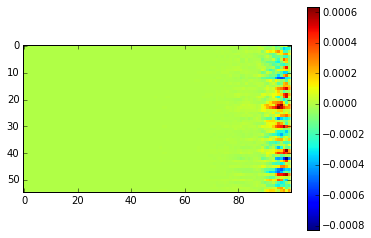

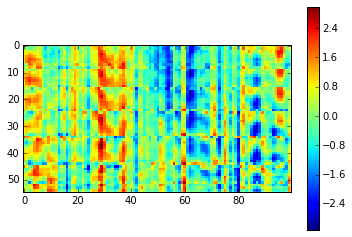

sample#73: target:0, probability_prediction:0.0175742246211


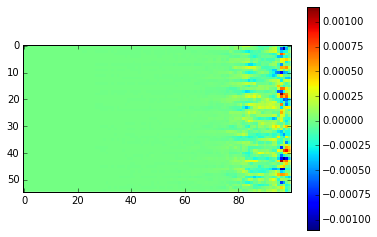

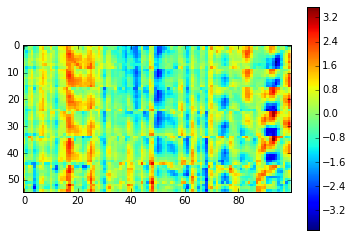

sample#74: target:1, probability_prediction:0.227026358247


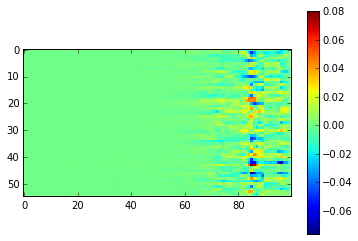

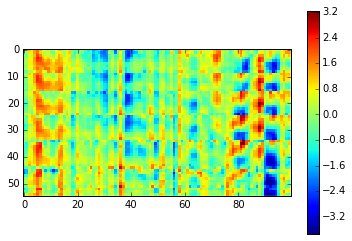

sample#75: target:0, probability_prediction:0.18259011209


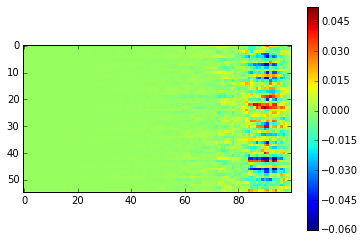

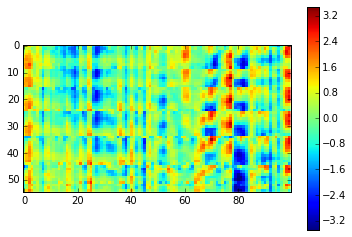

sample#76: target:0, probability_prediction:0.0220258478075


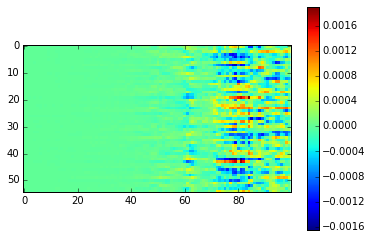

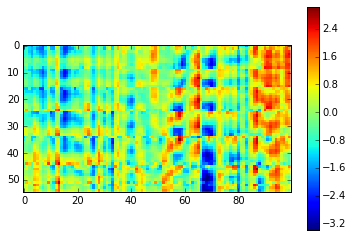

In [15]:
%matplotlib inline

for sample_i in [72,73,74,75,76]:
#     print test_prediction[sample_i,1 ]
    print "sample#{2}: target:{0}, probability_prediction:{1}".format(test_target_gcd[sample_i], test_prediction[sample_i,1 ], sample_i)
    data_to_diagnots =  stats.zscore(test_data_gcd, axis=1).astype('float32')[sample_i].reshape(1,100,55)
    
    temp = dlogistic(data_to_diagnots)
    temp.shape
    plt.imshow(temp[0,:,:].T, interpolation='none')
    plt.colorbar()
    plt.show()
    
    plt.imshow(data_to_diagnots[0,:,:].T, interpolation='none')
    plt.colorbar()
    plt.show()




In [41]:
model.layers[-1].get_output(train=False)[0]

# >>> x = T.dmatrix('x')
# >>> s = T.sum(1 / (1 + T.exp(-x)))
# >>> gs = T.grad(s, x)

Subtensor{int64}.0

In [43]:
result_func[0,:]

TypeError: unhashable type

In [57]:

x = T.dmatrix('x')
y = T.dmatrix('y')
z = x + y
f = theano.function([x, y], z[:,0])

In [58]:
f(np.asarray([[1,2]]), np.asarray([[1,2]]))

array([ 2.])

In [66]:
 T.grad(z[:,0],x)

TypeError: cost must be a scalar.

In [127]:
np.where(test_prediction[:,1 ] > 0.12)


(array([   38,    74,    75,    76,   103,   104,   178,   183,   187,
          188,   256,   276,   277,   339,   358,   359,   370,   371,
          396,   425,   451,   477,   530,   566,   589,   590,   646,
          653,   692,   693,   694,   747,   770,   771,   789,   790,
          845,   846,   847,   888,   911,   912,   913,   956,   957,
          958,  1020,  1047,  1064,  1068,  1166,  1188,  1276,  1286,
         1357,  1360,  1362,  1407,  1426,  1494,  1495,  1551,  1603,
         1671,  1738,  1765,  1816,  1817,  1827,  1828,  1829,  1857,
         1858,  1924,  1925,  1926,  1927,  1947,  1948,  1997,  1998,
         2020,  2051,  2111,  2112,  2150,  2151,  2168,  2169,  2234,
         2235,  2236,  2269,  2270,  2271,  2305,  2307,  2318,  2360,
         2440,  2441,  2442,  2443,  2491,  2492,  2525,  2526,  2527,
         2566,  2587,  2612,  2680,  2715,  2716,  2758,  2784,  2785,
         2793,  2794,  2847,  2848,  2875,  2920,  2997,  3057,  3058,
      

In [106]:
np.where(test_target_gcd == 1)

(array([    4,    39,    74,   104,   149,   159,   194,   214,   264,
          284,   316,   341,   371,   396,   431,   476,   486,   526,
          566,   596,   608,   658,   678,   693,   723,   753,   788,
          823,   848,   893,   912,   957,   982,   992,  1047,  1057,
         1092,  1127,  1167,  1187,  1220,  1255,  1275,  1305,  1335,
         1365,  1395,  1425,  1460,  1495,  1524,  1534,  1579,  1604,
         1624,  1679,  1709,  1724,  1754,  1789,  1801,  1841,  1876,
         1901,  1946,  1966,  1986,  2016,  2051,  2096,  2110,  2150,
         2165,  2200,  2235,  2270,  2305,  2330,  2365,  2395,  2402,
         2442,  2472,  2492,  2527,  2567,  2607,  2612,  2657,  2692,
         2718,  2758,  2788,  2808,  2838,  2868,  2893,  2928,  2963,
         2988,  3010,  3055,  3060,  3095,  3130,  3165,  3195,  3215,
         3250,  3285,  3308,  3353,  3363,  3393,  3423,  3478,  3498,
         3538,  3568,  3578,  3617,  3647,  3682,  3702,  3722,  3767,
      

In [131]:
test_data_gcd.shape, test_target_gcd.shape


((13800L, 40L, 55L), (13800L,))

In [132]:
# result_func = theano.function([model.get_input(train=False)], model.layers[-1].get_output(train=False)[:,0])
model.layers

In [133]:
precalssify_layer = theano.function([model.get_input(train=False)], model.layers[0].get_output(train=False))

In [141]:
middle_layer_test_data = precalssify_layer(stats.zscore(test_data_gcd, axis=1).astype('float32'))

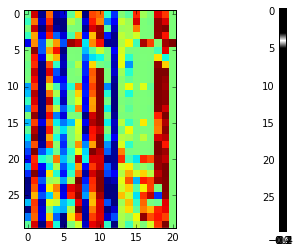

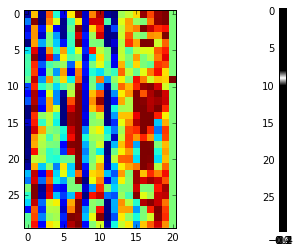

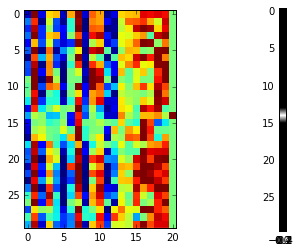

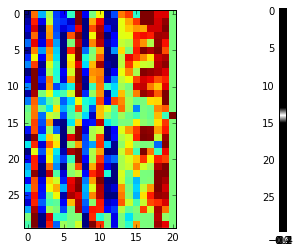

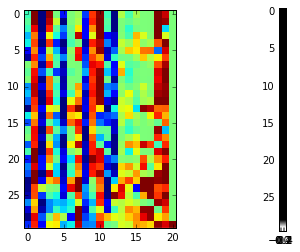

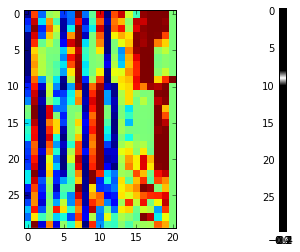

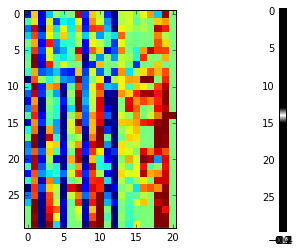

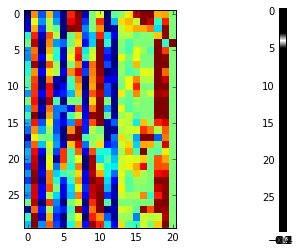

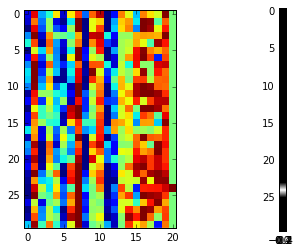

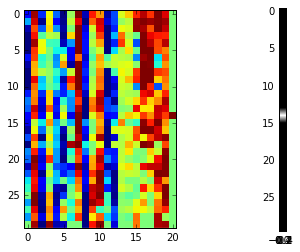

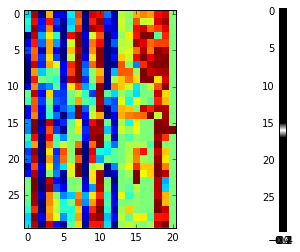

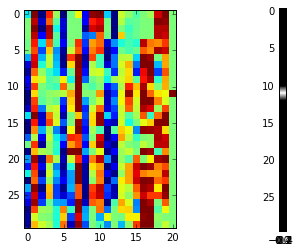

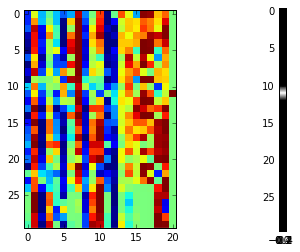

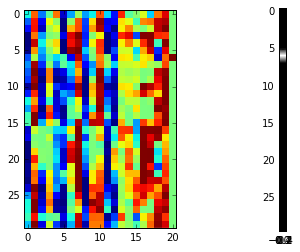

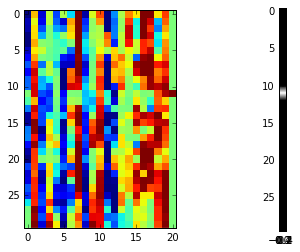

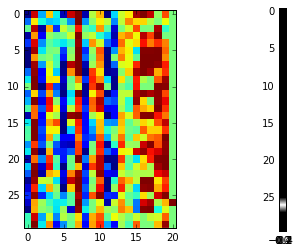

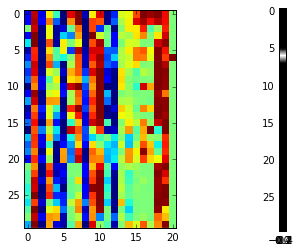

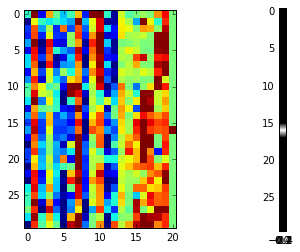

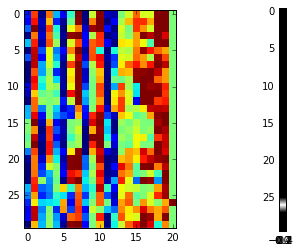

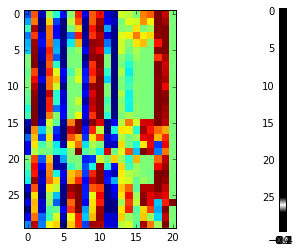

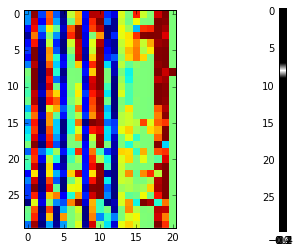

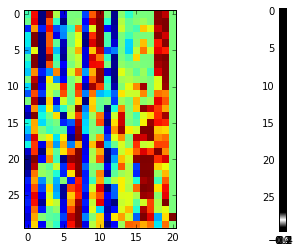

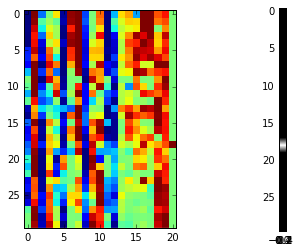

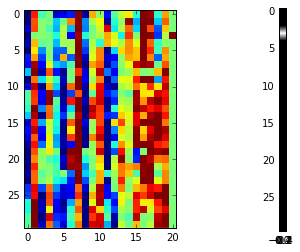

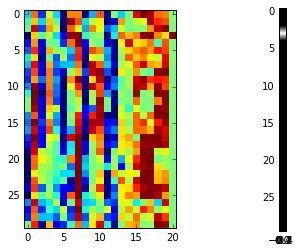

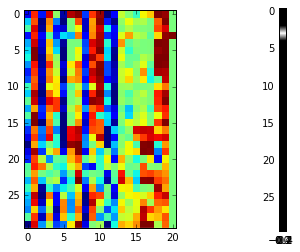

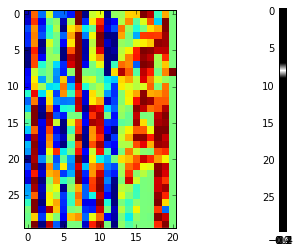

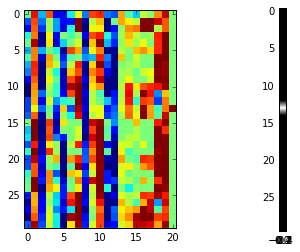

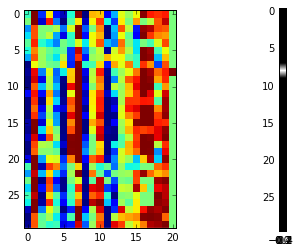

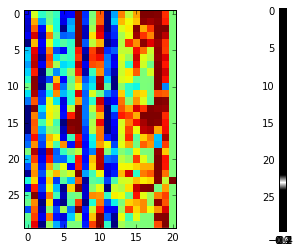

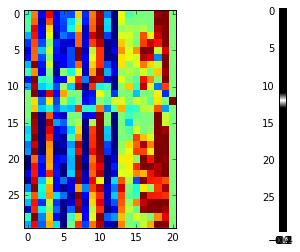

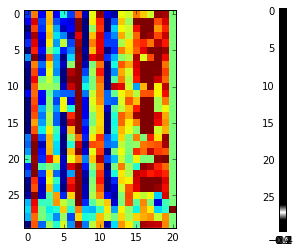

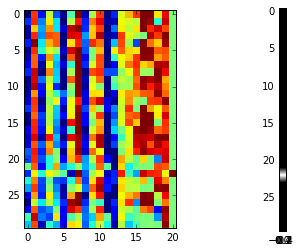

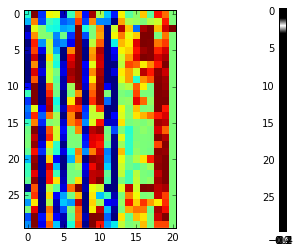

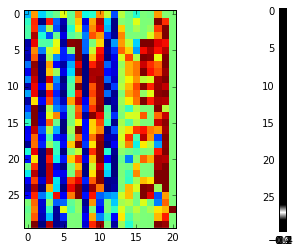

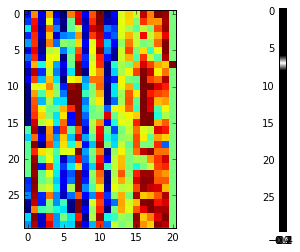

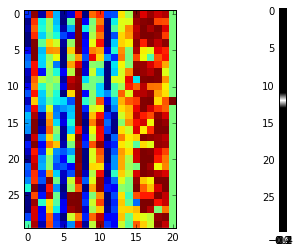

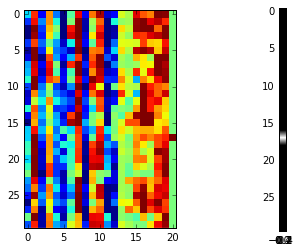

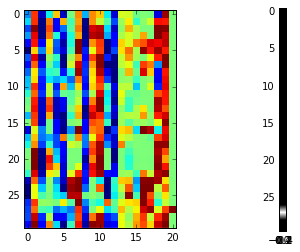

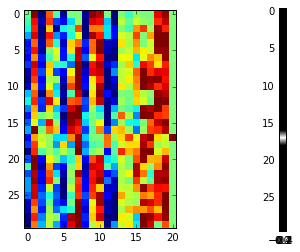

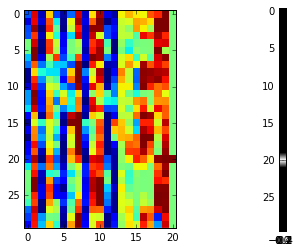

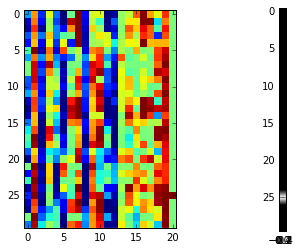

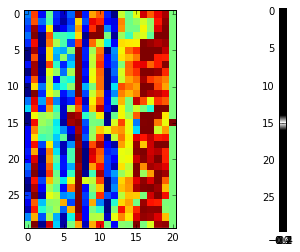

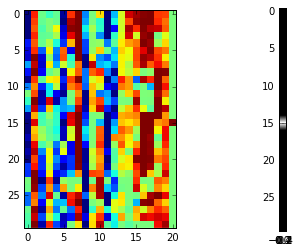

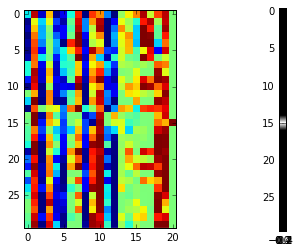

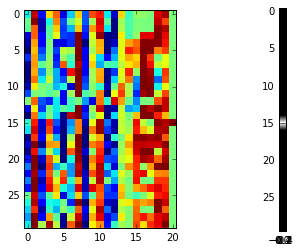

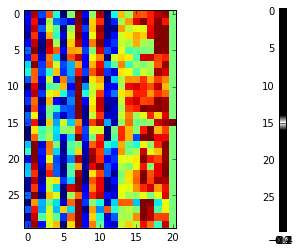

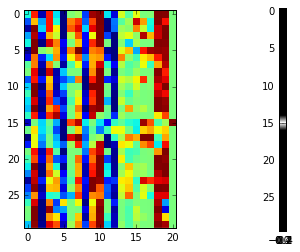

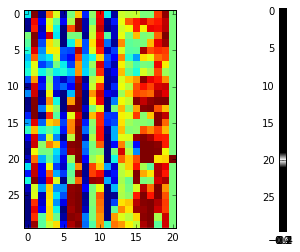

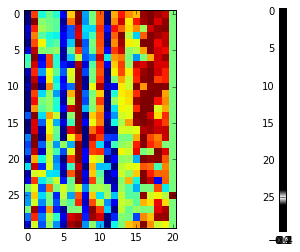

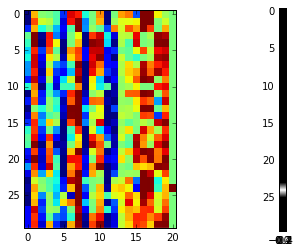

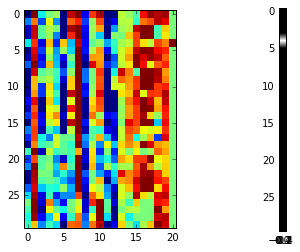

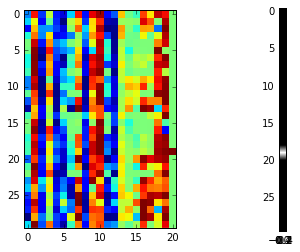

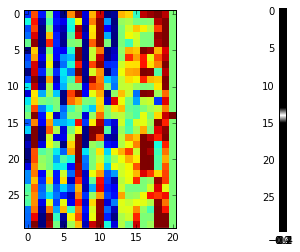

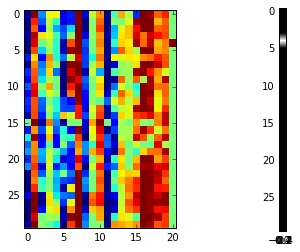

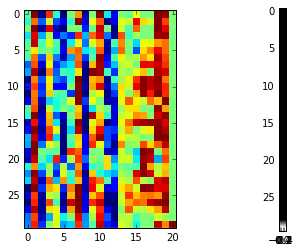

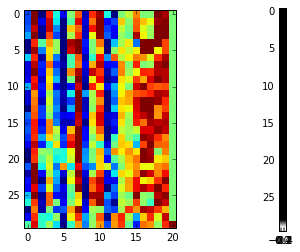

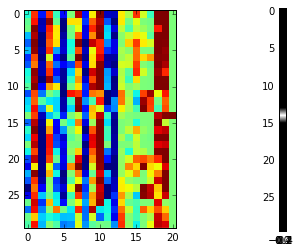

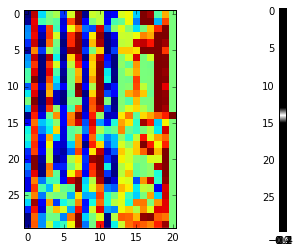

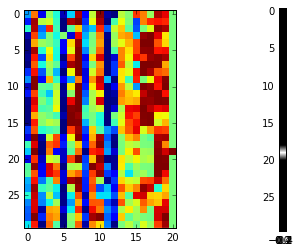

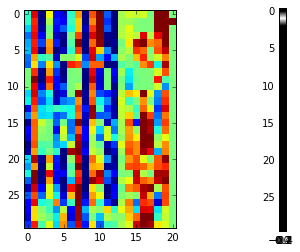

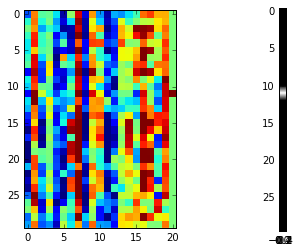

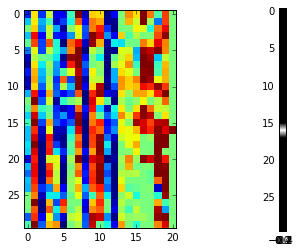

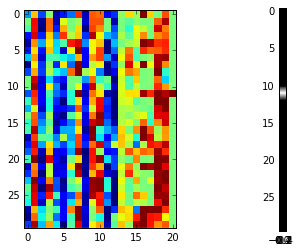

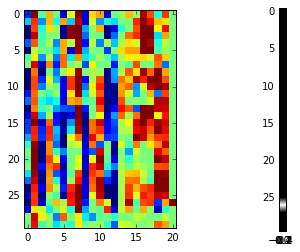

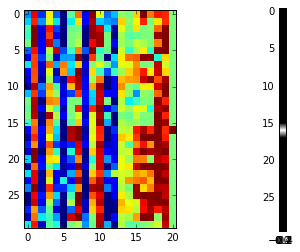

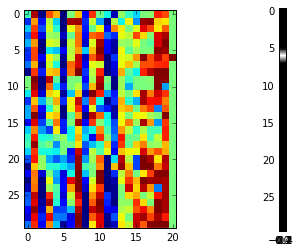

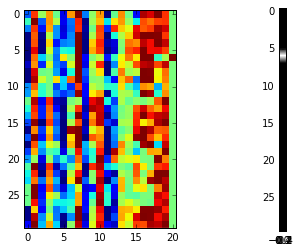

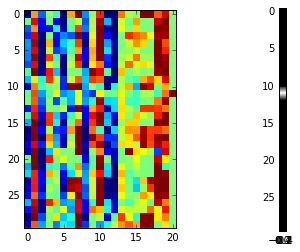

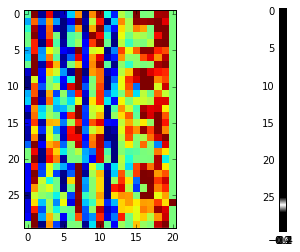

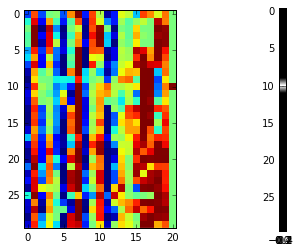

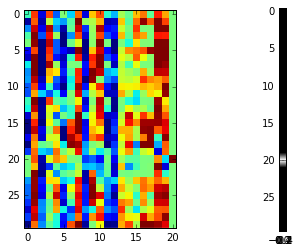

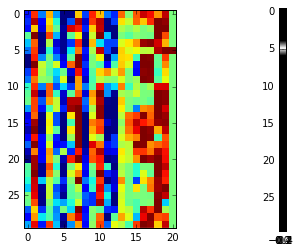

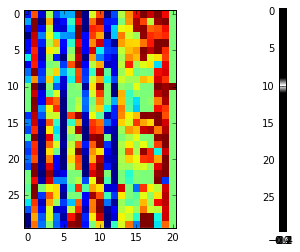

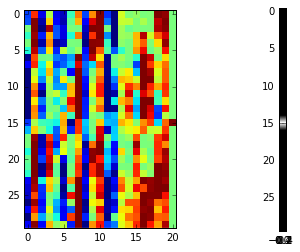

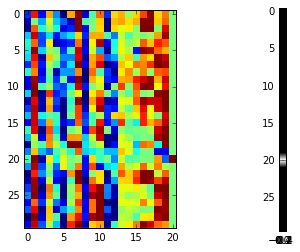

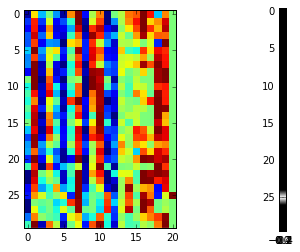

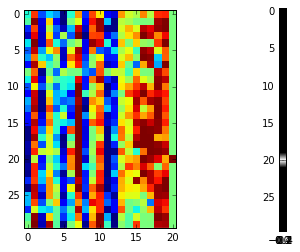

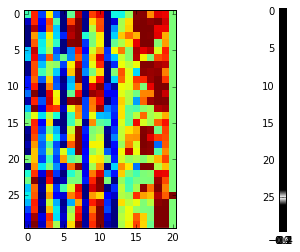

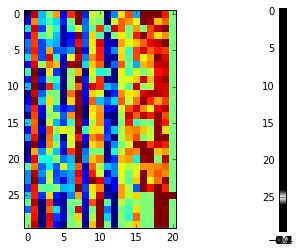

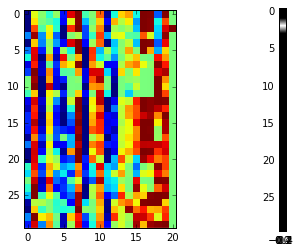

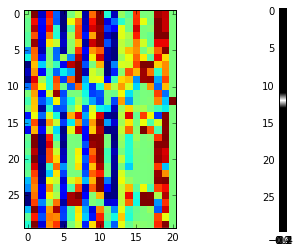

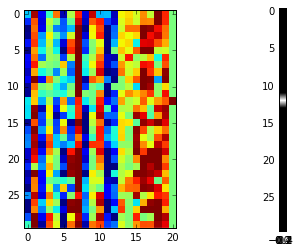

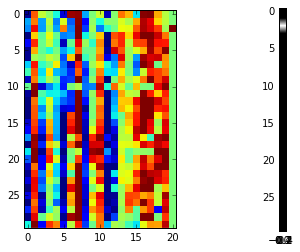

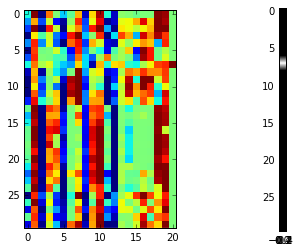

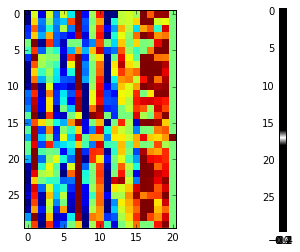

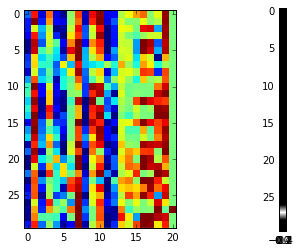

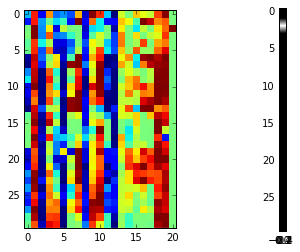

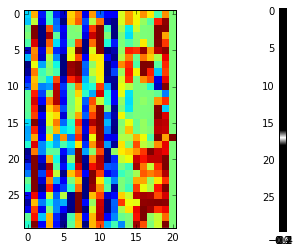

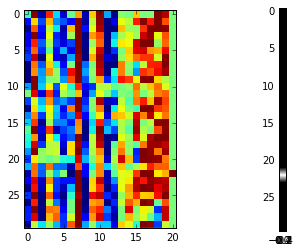

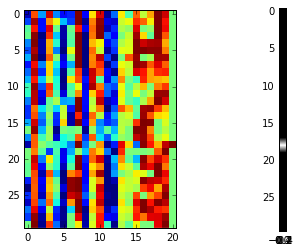

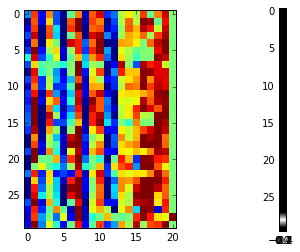

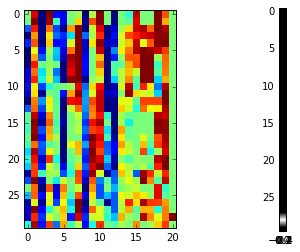

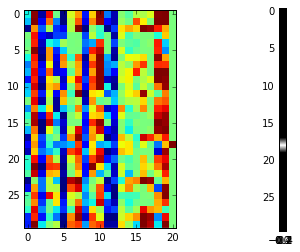

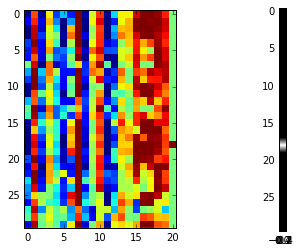

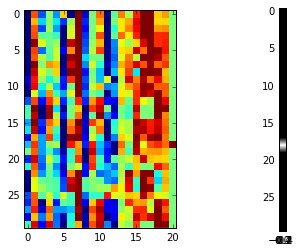

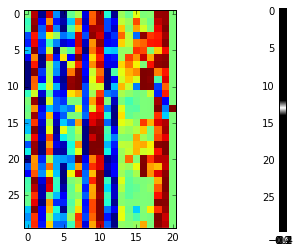

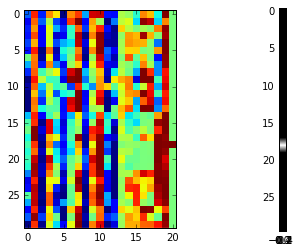

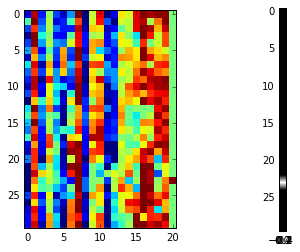

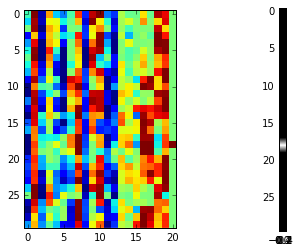

In [168]:
import matplotlib.cm as cm
for i in range(100):
    plt.subplot(1,2,1)
    plt.imshow(np.hstack([middle_layer_test_data[i*30:(i+1)*30,:], test_target_gcd.reshape(test_target_gcd.shape[0],1)[i*30:(i+1)*30]]) ,interpolation='none')
    plt.subplot(1,2,2)
#     print test_target_gcd.reshape(test_target_gcd.shape[0],1)
    plt.imshow(test_target_gcd.reshape(test_target_gcd.shape[0],1)[i*30:(i+1)*30],cmap = cm.Greys_r)
    plt.show()
#     plt.subplot(1,2,1)
#     plt.imshow(middle_layer_test_data[30:60,:],interpolation='none')
#     plt.subplot(1,2,2)
#     plt.imshow(test_target_gcd.reshape(test_target_gcd.shape[0],1)[30:60], cmap = cm.Greys_r)
#     plt.show()
#     reshaped_middle_layer_test_data = middle_layer_test_data.reshape(30,-1)
#     reshaped_middle_layer_test_data.shape

In [152]:
9200/20

460

In [179]:
from sklearn.decomposition import PCA
from sklearn.lda import LDA

C:\Anaconda\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


(13800L, 1L)


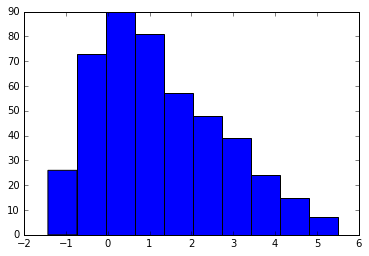

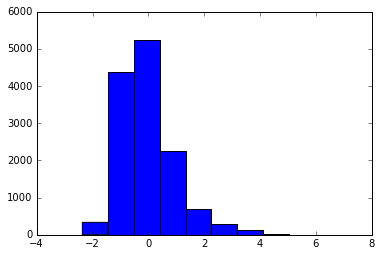

In [185]:
clf = LDA()
lda_res = clf.fit_transform(middle_layer_test_data, test_target_gcd)
print lda_res.shape
plt.hist(lda_res[test_target_gcd == 1])
plt.show()
plt.hist(lda_res[test_target_gcd == 0])
plt.show()


# pca = PCA(n_components=3)
# temp = pca.fit_transform(middle_layer_test_data)

In [176]:
temp.shape

(13800L, 3L)

AttributeError: Unknown property m

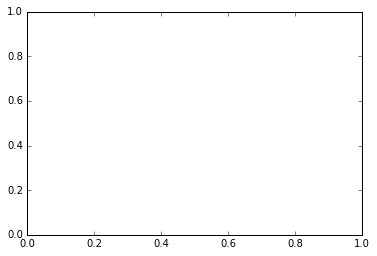

In [178]:
plt.scatter(temp[:,0], temp[:,1], temp[:,2], c=test_target_gcd)